In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
import statsmodels.api as sm
import plotly.graph_objects as go
import numpy as np
from pandas_datareader import data as wb
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

/Users/danvaldes/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Pandas display options to supress scientifc notation and show all columns and all rows if necessary. Puts a lot of strain of processor

In [2]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [3]:
nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
amex = pd.read_csv(os.path.join('Resources', 'amex.csv'))

frames = [nyse, nasdaq, amex]
tickers = pd.concat(frames).sort_values(by='Ticker')

In [4]:
data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

df['Market Cap Size'] = ['Large Cap' if x > 10000000000 else 'Mid Cap' if x > 2000000000 else 'Small Cap' for x in df['Market Cap']]

Note: In *__data_2018__* we had 4392 observations. When we merged with our *__tickers__* dataframe which had 8000+ tickers and company names from exchanges we lost 150 observations. These can be retrieved with 
``` 
data_2018[~data_2018.Ticker.isin(tickers['Ticker'])]
```
Here the **~** symbol essentially means NOT IN when we filter.\
Lastly, a dataframe with just indicators we can manipulate. We can filter out some of the columns containing information we don't need then pass this as a filter to our working dataframe with ```df[x['Indicator']]```

We can create a dataframe that counts the null values across each column to see what we can begin to drop. We can choose some threshold for amount of null values that once met causes us to drop the column. If we choose 500, our columns are trimmed to 183. If we count the null values across rows, we see that some companies are missing info on 150+ columns. These can be dropped as well. Our final set ends up being ~4000 rows long.

In [24]:
col_null_count = pd.DataFrame(df.isna().sum().sort_values(ascending=False))

In [36]:
row_null_count = pd.DataFrame(df.isnull().sum(axis = 1).sort_values(ascending=False))

In [30]:
null_count[col_null_count[0] >= 500];

In [27]:
to_drop = null_count[null_count[0] >= 500].index

In [41]:
df = df.drop(columns=to_drop)

In [63]:
df = df.dropna(thresh=100)

In [64]:
indicators = pd.DataFrame({
   'Indicator': df.iloc[:,2:-2].columns.tolist()
})

In [84]:
x = indicators[indicators['Indicator'].str.contains('Growth|Margin|ratio|Ratio|Turnover|per|/| / | to |Per|return|To|days') == False]

In [88]:
cond = x['Indicator'].to_list()

In [100]:
small_caps = df[df['Market Cap Size'] == 'Small Cap'].fillna(small_caps.mean())
mid_caps = df[df['Market Cap Size'] == 'Mid Cap'].fillna(mid_caps.mean())
large_caps = df[df['Market Cap Size'] == 'Large Cap'].fillna(large_caps.mean())

caps = [small_caps, mid_caps, large_caps]

market = pd.concat(caps)

market

,Ticker,Company Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class,Market Cap Size
3,AAMC,Altisource Asset,15926000.00,-0.12,0.00,15926000.00,0.00,22534000.00,22534000.00,-6608000.00,...,0.00,-0.18,-0.03,0.00,0.00,-0.12,Financial Services,-58.85,0,Small Cap
4,AAME,Atlantic Amer Cp,185553000.00,0.02,132650000.00,52903000.00,0.00,39042000.00,51837000.00,1066000.00,...,0.00,0.00,-0.09,0.00,0.00,-0.10,Financial Services,-20.25,0,Small Cap
6,AAOI,Applied Optoelect,267465000.00,-0.30,179692000.00,87773000.00,49903000.00,48638000.00,98541000.00,-10768000.00,...,0.23,0.03,-0.04,0.79,0.41,0.11,Technology,-25.19,0,Small Cap
7,AAON,Aaon Inc,433947000.00,0.07,330414000.00,103533000.00,0.00,47755000.00,47743000.00,55790000.00,...,0.10,0.04,0.05,0.00,0.00,-0.03,Basic Materials,41.83,1,Small Cap
10,AAT,American Assets Trust,330867000.00,0.05,121455000.00,209412000.00,0.00,22784000.00,129877000.00,79535000.00,...,0.00,-0.03,-0.04,-0.03,0.00,0.07,Real Estate,19.70,1,Small Cap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,XYL,Xylem Inc,5207000000.00,0.11,3181000000.00,2026000000.00,189000000.00,1161000000.00,1372000000.00,654000000.00,...,0.14,0.05,0.10,0.05,0.04,0.07,Industrials,19.97,1,Large Cap
4209,YUM,Yum! Brands,5688000000.00,-0.03,3030000000.00,2658000000.00,0.00,895000000.00,362000000.00,2296000000.00,...,0.00,-0.22,-0.35,0.03,0.00,-0.10,Consumer Cyclical,12.00,1,Large Cap
4211,YUMC,Yum China Holdings Inc,8415000000.00,0.08,6434000000.00,1981000000.00,0.00,456000000.00,1040000000.00,941000000.00,...,0.03,0.08,0.05,-0.11,0.00,-0.08,Consumer Cyclical,41.93,1,Large Cap
4216,ZBH,Zimmer Biomet Holdings,7932900000.00,0.02,2271900000.00,5661000000.00,391700000.00,3379300000.00,5627200000.00,33800000.00,...,0.09,-0.07,-0.05,-0.12,0.06,0.09,Healthcare,47.42,1,Large Cap


## Conditional Filtering

In [ ]:
tickers[tickers['Ticker'].str.startswith('BA') == True];

In [ ]:
tickers[tickers['Company Name'].str.contains('ETF') == True];

In [ ]:
df[df['Company Name'].str.contains('ETF') == True];

In [ ]:
df[df['Ticker'].str.startswith('BA') == True];

In [ ]:
df[df['Revenue Growth'] > 10].sort_values(by='Revenue', ascending=False).head()

# Iterators 

Sector breakdown across Market Cap Sizes

In [ ]:
count = pd.DataFrame(df.groupby(['Market Cap Size'])['Sector'].value_counts());

count_gen = count.groupby(['Market Cap Size']).__iter__()

In [ ]:
count_group_id, count_grouped_data = count_gen.__next__()
print(count_group_id) 
count_grouped_data

Iterate across Market Caps and Sectors

In [ ]:
mcap_gen = df.groupby(['Market Cap Size']).__iter__()
sector_gen = df.groupby(['Sector']).__iter__()

In [ ]:
market_group_id, market_grouped_data = mcap_gen.__next__()
print(market_group_id) 
market_grouped_data;

In [ ]:
sector_group_id, sector_grouped_data = sector_gen.__next__()
print(sector_group_id)
sector_grouped_data;

In [ ]:
scap_gen = small_caps.groupby(['Sector']).__iter__()

In [ ]:
scap_group_id, scap_grouped_data = scap_gen.__next__()
print(scap_group_id) 
scap_grouped_data.sort_values(by='Revenue Growth', ascending=False)

In [ ]:
assets = scap_grouped_data['Ticker'].to_list()

pf_data = pd.DataFrame()

for a in assets:
    pf_data[a] = wb.DataReader(a, data_source = 'yahoo', start = '2018-1-1')['Adj Close']


In [ ]:
mcap_gen = mid_caps.groupby(['Sector']).__iter__()

In [ ]:
mcap_group_id, mcap_grouped_data = mcap_gen.__next__()
print(mcap_group_id) 
mcap_grouped_data.sort_values(by='Revenue Growth', ascending=False)

In [ ]:
assets = mcap_grouped_data['Ticker'].to_list()

pf_data = pd.DataFrame()

for a in assets:
    pf_data[a] = wb.DataReader(a, data_source = 'yahoo', start = '2018-1-1')['Adj Close']


In [101]:
lcap_gen = large_caps.groupby(['Sector']).__iter__()

In [111]:
lcap_group_id, lcap_grouped_data = lcap_gen.__next__()
print(lcap_group_id) 
lcap_grouped_data.sort_values(by='Revenue Growth', ascending=False)

Consumer Cyclical


,Ticker,Company Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class,Market Cap Size
3827,TSLA,Tesla Inc,21461268000.00,0.83,17419247000.00,4042021000.00,1460370000.00,2834491000.00,4430094000.00,-388073000.00,...,0.38,0.04,0.13,0.16,0.06,0.14,Consumer Cyclical,34.89,1,Large Cap
403,BABA,Alibaba Group Holding,39592785951.59,0.72,16934662236.99,22658123714.60,3599746875.49,6888150609.08,11692453725.68,10965669988.93,...,0.00,0.54,0.40,0.49,0.45,0.66,Consumer Cyclical,55.16,1,Large Cap
2226,LEN,Lennar Corp,20571631000.00,0.63,18237446000.00,2334185000.00,0.00,343934000.00,496914000.00,1837271000.00,...,0.57,0.52,0.32,0.33,0.00,0.20,Consumer Cyclical,40.06,1,Large Cap
1111,DISCA,Discovery Comm A,10553000000.00,0.54,3935000000.00,6618000000.00,0.00,2620000000.00,4768000000.00,1850000000.00,...,0.00,0.44,0.40,0.14,0.00,0.48,Consumer Cyclical,26.75,1,Large Cap
3778,TPR,Tapestry Inc,5880000000.00,0.31,2031500000.00,3848500000.00,0.00,3177700000.00,3177700000.00,670800000.00,...,0.43,0.15,0.06,0.01,0.00,0.39,Consumer Cyclical,-17.58,0,Large Cap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,FCAU,Fiat Chrysler Automobiles N.V.,126910344827.59,-0.00,109208045977.01,17702298850.57,3506896551.72,8411494252.87,12036781609.20,5665517241.38,...,-0.21,-0.04,0.13,-0.22,0.01,-0.02,Consumer Cyclical,18.90,1,Large Cap
4209,YUM,Yum! Brands,5688000000.00,-0.03,3030000000.00,2658000000.00,0.00,895000000.00,362000000.00,2296000000.00,...,0.00,-0.22,-0.35,0.03,0.00,-0.10,Consumer Cyclical,12.00,1,Large Cap
3146,RACE,Ferrari N.V.,3931403448.28,-0.04,1865408045.98,2065995402.30,739124137.93,376254022.99,1115378160.92,950617241.38,...,-0.05,0.12,0.66,0.03,-0.06,-0.05,Consumer Cyclical,69.12,1,Large Cap
2368,MCD,McDonald's Corp,21025200000.00,-0.08,10239200000.00,10786000000.00,0.00,2200200000.00,1963400000.00,8822600000.00,...,-0.13,-0.03,-0.99,0.05,0.00,-0.01,Consumer Cyclical,14.95,1,Large Cap


In [112]:
assets = lcap_grouped_data['Ticker'].to_list()

pf_data = pd.DataFrame()

for a in assets:
    pf_data[a] = wb.DataReader(a, data_source = 'yahoo', start = '2018-1-1')['Adj Close']

(pf_data / pf_data.iloc[0] * 100).iplot(asFigure=True)

## Graphs and Visualizations

Count of Companies by Sector

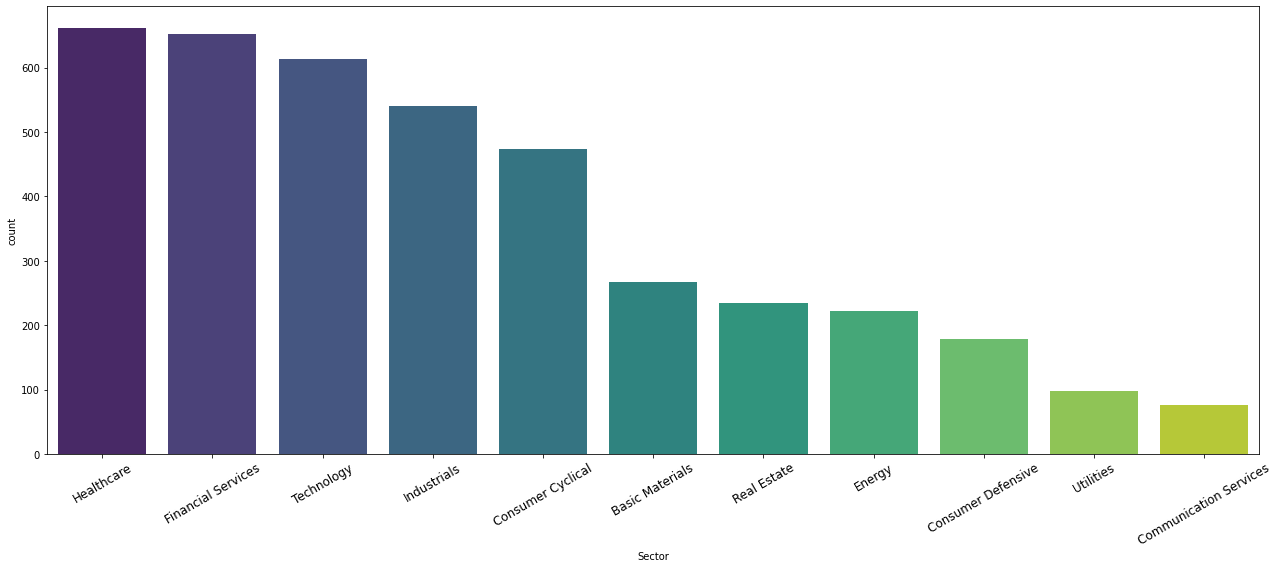

In [106]:
plt.figure(figsize=(18,8))
sns.countplot(x='Sector', data = df, palette='viridis', order=df['Sector'].value_counts().index).set_xticklabels(labels = df['Sector'].value_counts().index, fontdict={'fontsize': 12},rotation=30)
plt.tight_layout()
plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

Revenues by Sector

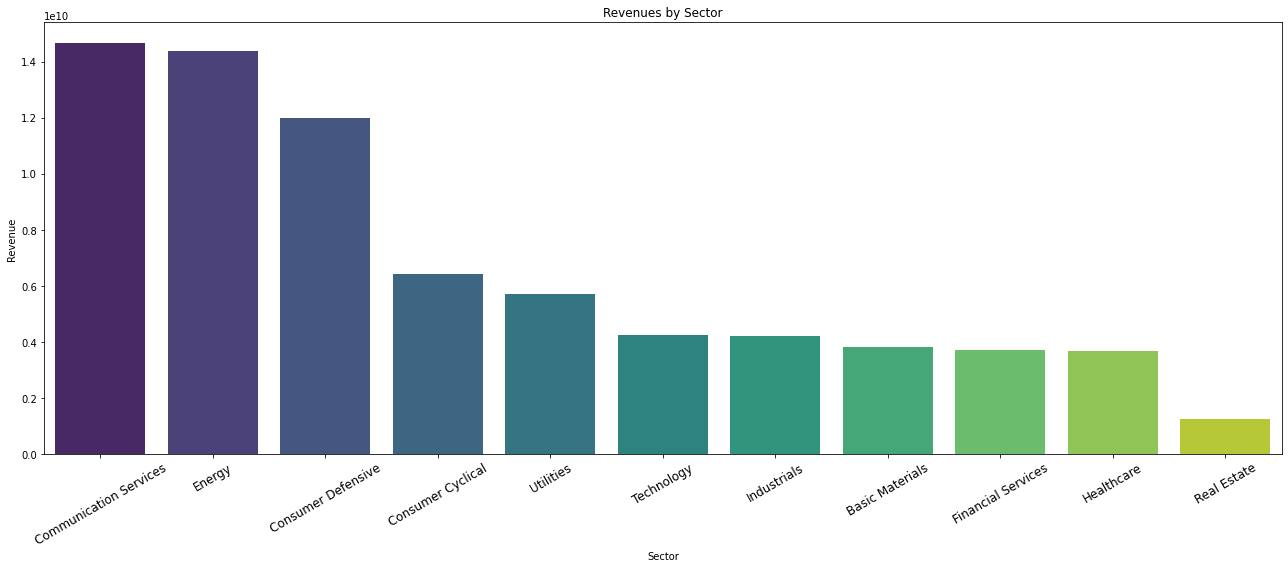

In [107]:
sector_rev = pd.DataFrame(df.groupby(['Sector']).mean()['Revenue']).reset_index().sort_values(by='Revenue', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Revenues by Sector')
sns.barplot(x = sector_rev['Sector'], y = sector_rev['Revenue'], palette='viridis',).set_xticklabels(labels = sector_rev['Sector'], fontdict={'fontsize': 12}, rotation=30)
plt.tight_layout();
plt.savefig(os.path.join('Figures','SectorRev.png'))

Count of Companies across Market Cap Sizes

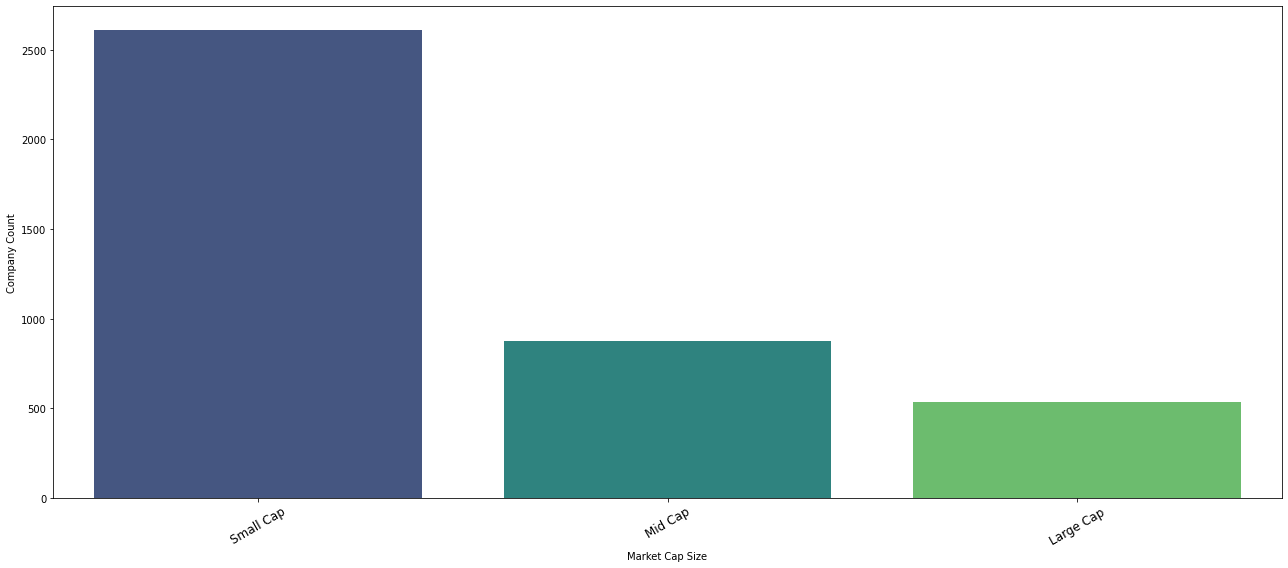

In [96]:
plt.figure(figsize=(18,8))
sns.countplot(x='Market Cap Size', data = df, palette='viridis', order=df['Market Cap Size'].value_counts().index).set_xticklabels(labels = df['Market Cap Size'].value_counts().index, fontdict={'fontsize': 12},rotation=30)
plt.tight_layout()
plt.ylabel('Company Count')
plt.savefig(os.path.join('Figures','MarketCapBreakdown.png'))

In [ ]:
bars = []
sectors = df['Sector'].unique()
caps=['Small Cap', 'Mid Cap', 'Large Cap']
for sector in sectors:
    bars.append(go.Bar(name=sector, x=caps, y=np.array(df[df['Sector'] == sector]['Market Cap Size'].value_counts())))

plt.figure(figsize=(30,12))
fig = go.Figure(data=bars)
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

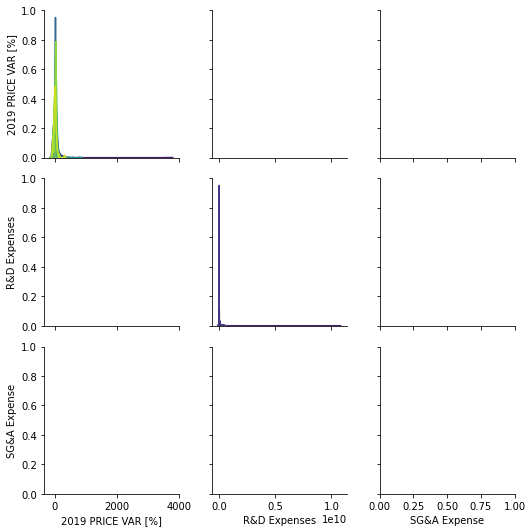

In [108]:
sns.pairplot(df, vars = ['2019 PRICE VAR [%]', 'R&D Expenses', 'SG&A Expense',], dropna = True, hue='Sector', palette='viridis')

In [ ]:
df[cond].cov();

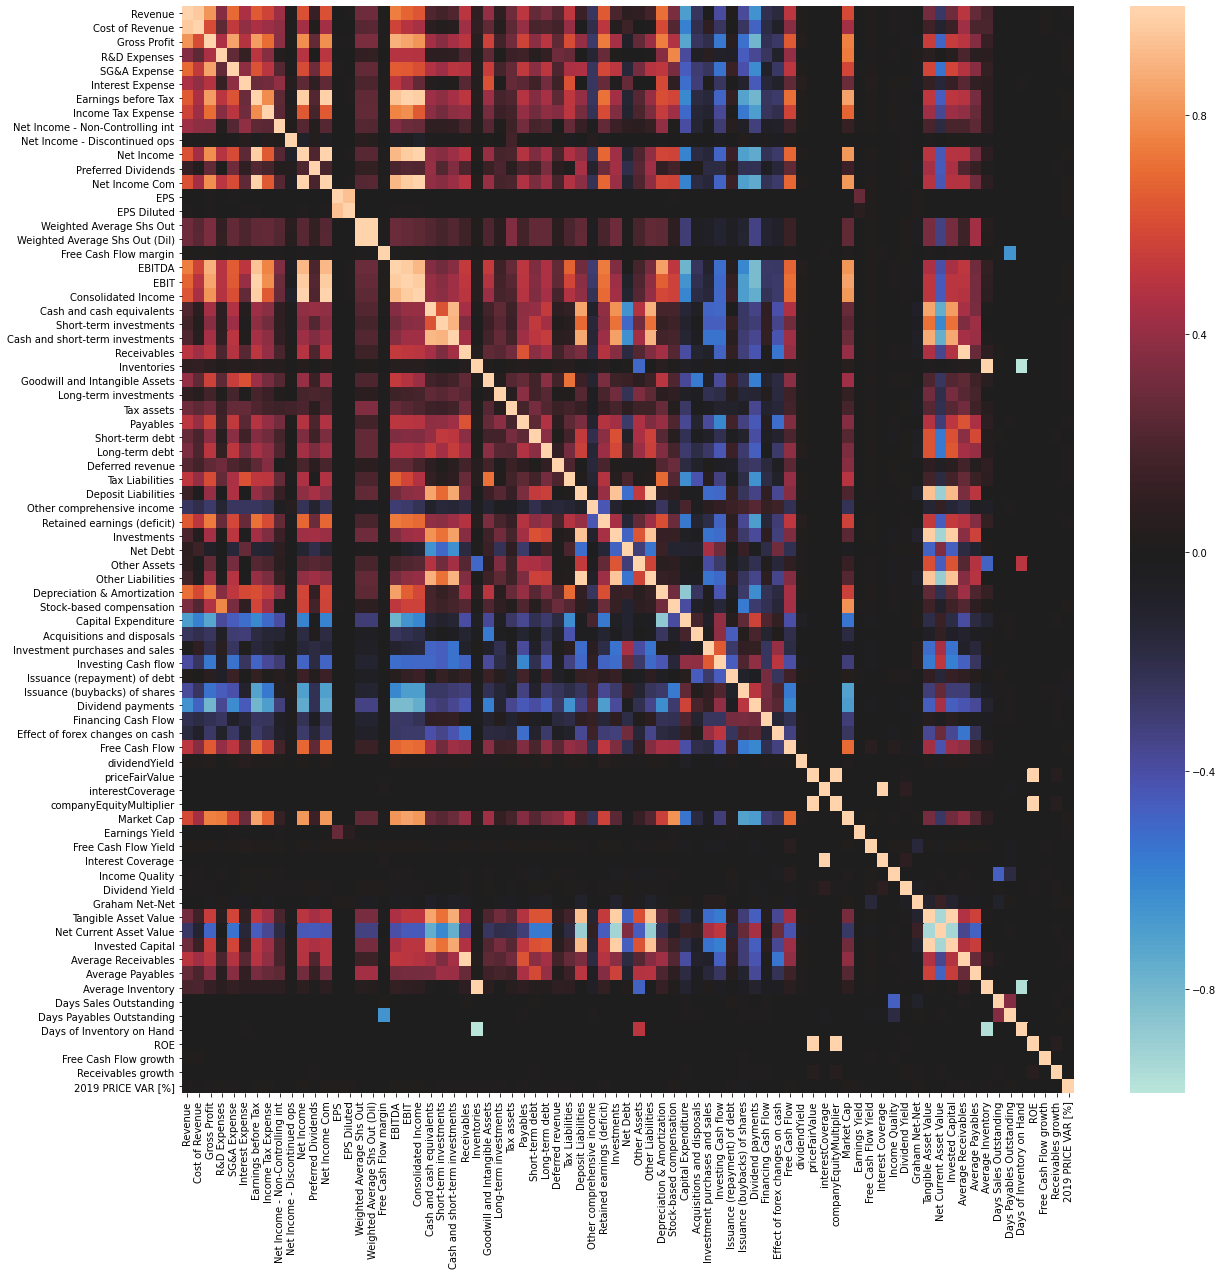

In [91]:
corrs = df[cond].corr()

plt.figure(figsize=(20,20))
g = sns.heatmap(corrs, center=0)

## Regression Analysis

In [ ]:
y = df["2019 PRICE VAR [%]"]

X = sm.add_constant(df[x['Indicator']].fillna(0))

reg = sm.OLS(y, X).fit()

reg.summary();

In [ ]:
# df.to_csv(os.path.join('2018_data.csv'))